<a href="https://colab.research.google.com/github/DomMc97/Climbing_Data/blob/master/classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification to Predict Success of an Ascent.

A notebook which uses classification techniques to predict whether an attempted climb of Mt. Rainier will be successful dependent on the four weather features ‘Temperature’, ‘Relative Humidity’, ‘Wind Speed Daily’ and ‘Solar Radiation’ on the day of the climb.


---

## Set Up

Import libraries.

In [1]:
# scientific library
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

# data analytics library
import pandas as pd

# sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics

# libraries for saving/loading data
import pickle
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
upload = files.upload()

Saving mtRainier.csv to mtRainier.csv
Saving test_set.csv to test_set.csv


## Unfolding of Data
Unfoldong of the Mt. Rainier data so that each row
contains a sucess variable that is binary, i.e., ‘success=1’ or ‘failure=0’ for each
attempt. 


---



Loads cleaned dataset.

In [3]:
mtRainier = pd.read_csv('mtRainier.csv', index_col=0)

# display data
print('Merged climbing statistics and weather dataset.\n')
print('Size:', mtRainier.shape)
mtRainier.head()

Merged climbing statistics and weather dataset.

Size: (483, 10)


,Date,Route,Attempted,Succeeded,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solar Radiation AVG
0,2014-09-23,Disappointment Cleaver,11,0,0.000000,32.857333,100.000000,65.110667,254.273333,16.593800
1,2014-09-24,Disappointment Cleaver,12,0,0.000000,29.702917,100.000000,45.915000,278.054167,37.873708
2,2014-09-25,Disappointment Cleaver,14,8,0.571429,26.823750,99.854167,3.166208,278.604167,142.698917
3,2014-09-26,Disappointment Cleaver,41,19,0.463415,28.238333,100.000000,0.897625,259.645833,114.400833
4,2014-09-27,Disappointment Cleaver,44,25,0.568182,33.318750,60.200417,7.140917,116.294583,227.597125


Replace Attempted and Succeeded column with a binary vector of attempts and whether they are successful. Then explode this column of vectors.

In [4]:
def unfold(df):
    """ 
    Unfolds a dataframe with Succeded and Attempted columns into a dataframe of 
    attempts and a binary success column.
    """

    def binarise(row):
        """
        Takes a row of a dataframe and uses the Attempted and Succeded values 
        in the row to create a binary vector of attempts.
        """

        #attempts and successes
        att = row['Attempted']
        succ = row['Succeeded']

        # binary vector of attempts: successful=1, failure=0
        binary = np.concatenate((np.ones(succ), np.zeros(att-succ)))
        
        return binary
    
    # add a binary column which encapsulates Attempted and Succeeded column
    df['Success'] =  df.apply(lambda row: binarise(row), axis=1)

    # drop Attempted, Succeeded and Success Percentage columns
    df = df.drop(['Attempted', 'Succeeded','Success Percentage'], axis = 1)

    # explode the Success column
    df = df.explode('Success')

    # reset index
    df = df.reset_index(drop = True)

    return df

# unfolds df
mtRainier = unfold(mtRainier)

# display data
print('Updated dataframe.\n')
print('Size:', mtRainier.shape)
mtRainier.head()

Updated dataframe.

Size: (10134, 8)


,Date,Route,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solar Radiation AVG,Success
0,2014-09-23,Disappointment Cleaver,32.857333,100.0,65.110667,254.273333,16.5938,0
1,2014-09-23,Disappointment Cleaver,32.857333,100.0,65.110667,254.273333,16.5938,0
2,2014-09-23,Disappointment Cleaver,32.857333,100.0,65.110667,254.273333,16.5938,0
3,2014-09-23,Disappointment Cleaver,32.857333,100.0,65.110667,254.273333,16.5938,0
4,2014-09-23,Disappointment Cleaver,32.857333,100.0,65.110667,254.273333,16.5938,0


## Training and Validation Split

This section splits the data into a training, validation split and loads a test dataset. All this data is split into x: predictor, y: class pairs.


---



Split into 2 datasets: X of the predictors (weather variables) and y of the binary success classes.

In [5]:
X = mtRainier[[ 'Temperature AVG', 'Relative Humidity AVG',
               'Wind Speed Daily AVG', 'Solar Radiation AVG' ]]
y = mtRainier['Success']

Split the data into a training set, with 80%, of the rows for the training of the models and a validation set, with 20% of the rows, for the insample validation of the accuracy of the model. The split is stratified in order to enforce a well sampled split in terms of the target 'Success' classes. The training and validation sets are then split into x: predictor, y: class pairs.

In [6]:
# stratified test train split
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y, 
                                                      test_size=0.2, 
                                                      stratify=y, 
                                                      random_state=0)
# convert target to binary
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

Normalise the data to produce a common scale for predictors to remove a skew to the importance of 'Solar Radiation' as a predictor.

In [7]:
# scaling function
scaler = StandardScaler()

# fit scaler
scaler.fit(X_train)

# transform X_train and X_valid according to this scale
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

Loads Test dataset an out-of-sample data set of the weather conditions and success percentages from 28-31 December 2018.

In [8]:
test = pd.read_csv('test_set.csv')

# display data
print('Test dataset.\n')
print('Size:', test.shape)
test.head()

Test dataset.

Size: (4, 5)


,Date,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Solar Radiation AVG
0,12/31/2018,24.062910,58.87083,17.977790,121.91529
1,12/30/2018,44.631200,53.49383,13.540541,191.19283
2,12/29/2018,22.614291,60.07291,10.451290,157.10091
3,12/28/2018,31.687041,70.55791,9.876980,176.24120


Normalise the test variables.

In [9]:
# scale predictor variables
X_test = scaler.transform(test[[ 'Temperature AVG',
                                'Relative Humidity AVG',
                                'Wind Speed Daily AVG',
                                'Solar Radiation AVG' ]])

# update test to contain normalised variables
test.iloc[:,1:] = X_test

## Logistic Regression

Logistic regression is a classification method which uses the predictor variables to predict a binary outcome for example a Success (1) or Fail (0).

The Logistic regression model is built of the assumption that the log odds are a linear combination of descriptors. That is: $$\beta_{0} + \beta_{1} x_{0} + ... \beta_{p} x_{p} = \vec{x}^{T} \cdot \vec{\beta} = \log{\frac{\mathbb{P}(y = 1)}{\mathbb{P}(y = 0)}} = \log{\frac{\mathbb{P}(y = 1)}{1 - \mathbb{P}(y = 1)}} \implies \mathbb{P}(y = 1) = \frac{1}{1 + \exp{-\vec{x}^{T} \cdot \vec{\beta}}} = h_{\vec{\beta}}(\vec{x})$$

Using this we can then model $\mathbb{P}(Y=y; \vec{x}, \vec{\beta}) = h_{\vec{\beta}}(\vec{x})^{y}(1 - h_{\vec{\beta}}(\vec{x}))^{1-y}$ then assuming independence between our samples then taking logs we can obatain the maximum likelihood cost function which we'd like to minimise of: 

$$L = -\sum\limits_{i}^{N} y_{i} \log{(h_{\vec{\beta}}(\vec{x}_{i}))} + (1- y_{i}) \log{(1 - h_{\vec{\beta}}(\vec{x}_{i}))} $$ 

When optimised we can class an outcome as a success if the probability is above a decision boundary $T$ which is generally set as T = 1/2. 

$$y_{pred} = 1 \iff \mathbb{P}(y = 1)  = h_{\vec{\beta^{*}}}(\vec{x}) > T $$


---





I trained a logistic regression classifier on the training data with the weather variables ‘Temperature’, ‘Relative Humidity’, ‘Wind Speed Daily’ and ‘Solar Radiation’ as features and the binary success of summiting Mount Rainier as the output with a decsiion boundary of T = 1/2. 

Initialise model.

In [10]:
# create model
Log_model = LogisticRegression()

Fit model.

In [11]:
#fits model
Log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The probability of a succcessful summit from the validation set.

In [12]:
#makes predictions on validation set
pred_valid = Log_model.predict(X_valid)

#number of succesful attempts
successes = np.sum(pred_valid)

#number of attempts
attempts = len(pred_valid)

#success probability
prob = 100*successes/attempts

print('The probablity to to successfully summit on the validation data is ' \
      '%.2f'%prob + '%.')

The probablity to to successfully summit on the validation data is 57.08%.


The quality of the model is then quantified. All the  measures below are calculated where a score of 1 is the best case and 0 worse.

**Accuracy:** The percentage of correct predictions.

**Confusion Matrix:** Matrix of predictions. Where the columns are the True labels and the rows are the predicted.

|   | 1 | 0 |
|---|---|---|
| 1 | TP| FP|
| 0 | FN| TN|

**Precision:** Precision is the ratio $\frac{TP}{TP + FP}$ this is intutitively the ability of a classifier not to label a negative sample as positive. 

**Recall:** Recall is the ratio $\frac{TP}{TP + FN}$ this is intutitively the ability of a classifier to find all positive samples.

**F1 Score:**
The F1 score can be interpreted as a weighted average of the precision and recall. $$F1 = 2 \frac{precision \times recall}{precision + recall}$$

**Receiver operating characteristic (ROC):** The ROC curve is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings.




In [13]:
def quality(X, y, model, name, dataset):
    """
    Function which returns quality measures of a supervised classification of a
    binary outcome.
    Inputs:
        X: Predictor dataset.
        y: Binary outcome datset.
        model: Fitted classification model. 
        name: Name of model.
        dataset: Training, Test or Validation quality.
    """
    #makes predictions on training set
    pred = model.predict(X)

    # accuracy metrics
    acc = metrics.accuracy_score(y, pred)
    pre = metrics.precision_score(y, pred)
    recall = metrics.recall_score(y, pred)
    F1 = metrics.f1_score(y, pred)
    mat = metrics.confusion_matrix(y, pred, labels=[1, 0])

    print('The ' + dataset + ' accuracy of ' + name + ' is %.2f.'%acc)
    print('The ' + dataset + ' precision of ' + name + ' is %.2f.'%pre)
    print('The ' + dataset + ' recall of ' + name + ' is %.2f.'%recall)
    print('The ' + dataset + ' F1 of ' + name + ' is %.2f.\n'%F1)

    # confusion matrix
    ax = sns.heatmap(mat.T, annot=True,fmt='.0f',cbar=False,
                    xticklabels=[1, 0], yticklabels=[1, 0])
    ax.tick_params(axis='both', which='major',labelbottom = False,
                  bottom=False, top = False, labeltop=True)
    ax.set_ylabel('Predicted')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('True')
    ax.set_title('Confusion Martix')
    plt.show()
    return

Quality of predictions on training set.

The training accuracy of Logistic Regression is 0.61.
The training precision of Logistic Regression is 0.58.
The training recall of Logistic Regression is 0.68.
The training F1 of Logistic Regression is 0.62.



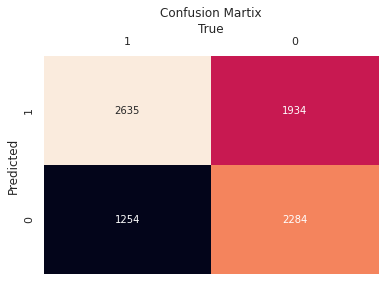

In [14]:
quality(X_train, y_train, Log_model, 'Logistic Regression', 'training')

Quality of predictions on validation set.

The validation accuracy of Logistic Regression is 0.61.
The validation precision of Logistic Regression is 0.58.
The validation recall of Logistic Regression is 0.69.
The validation F1 of Logistic Regression is 0.63.



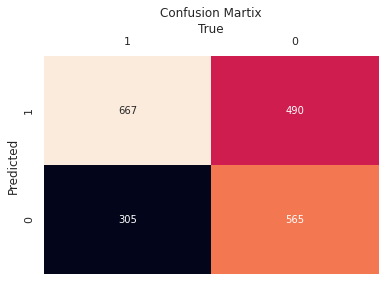

In [15]:
quality(X_valid, y_valid, Log_model, 'Logistic Regression', 'validation')

Roc curve comparision of training and validation set.

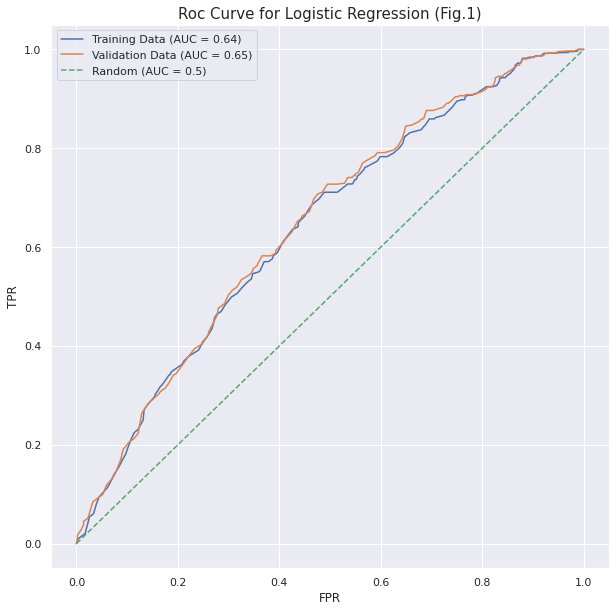

In [16]:
# obtain prediction probablilities
probs_train = Log_model.predict_proba(X_train)[:, 1]
probs_valid = Log_model.predict_proba(X_valid)[:, 1]

# obtain TPR, FPR an AUC for training and validation data.
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, probs_train)
auc_train = metrics.roc_auc_score(y_train, probs_train)
fpr_valid, tpr_valid, _ = metrics.roc_curve(y_valid, probs_valid)
auc_valid = metrics.roc_auc_score(y_valid, probs_valid)

# plot results
fig = plt.figure(figsize=(10, 10))
plt.title('Roc Curve for Logistic Regression (Fig.1)', fontsize='15')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr_train, tpr_train, label='Training Data (AUC = %.2f)'%auc_train)
plt.plot(fpr_valid, tpr_valid, label='Validation Data (AUC = %.2f)'%auc_valid)
plt.plot([0, 1], [0, 1], linestyle= '--', label='Random (AUC = 0.5)')
plt.legend()
plt.show()

The performance on both the training and validation set seems to be very similar which inicates the model has been well fitted. Most the scores are of the order of 0.6 which suggests that the model is performing slightly better than random. We have a relatively high recall and low precision which indicates a slight overprediction of success with many FP although we do manage to find a large proportion of TP with this model.

## Naive-Bayes

The Naive-Bayes classifier, takes a set of predictors and from this makes a prediction to which class the sample is in.

It is based on Bayes' Theorem:

$$\mathbb{P}(Y = y|X = \vec{x}) = \frac{\mathbb{P}(X = \vec{x}| Y = y) \mathbb{P}(Y=y)}{\mathbb{P}(X = \vec{x})}$$

With the assumptions that:

$$\mathbb{P}(Y = y) = \frac{1}{N} \sum\limits_{i=1}^{N} I(y_{i} = y)$$ where $I(A)$ is the inidicator of being A. This is the frequency of each class in the training set. 

$$\mathbb{P}(X = \vec{x}| Y = y) = \prod\limits_{j = 1}^{p} \mathbb{P}(X_{j} = x_{j} | Y = y)$$ the Naive assumption that the despriptors are independent of eachother. This is wrong but often works. This is found by estimating from the data set.

With the following estimation with Laplace smoothing to solve the issue of 0 probablity $Q$ is the number of classes.
$$\mathbb{P}(X_{j} = x_{j} | Y = y) = \frac{[\sum\limits_{i=1}^{N} I(X_{j}^{i} = x_{j} \wedge y_{i} = y)] + \lambda}{[\sum\limits_{i=1}^{N} I(y_{i} = y)] + \lambda Q}$$ 


$$\mathbb{P}(X = \vec{x}) = \sum\limits_{q=1}^{Q} \mathbb{P}(X = \vec{x} | Y = y_{q}) \mathbb{P}(Y = y_{q}) $$ by the law of total probability.

We can use this to find a vector of probabilities to be in ecah class, the prediction made be Naive-Bayes is the arg maximum of this vector. That is the outcome is the class with the highest probability.

$$\mathbb{P}(X = \vec{x}| Y = y)$$ can also be estimated by assuming a Gaussian Distribution with a sampled mean and variance. 

---



I trained a Naive-Bayes classifier on the training data with the weather variables ‘Temperature’, ‘Relative Humidity’, ‘Wind Speed Daily’ and ‘Solar Radiation’ as features and the binary success of summiting Mount Rainier as the output. 

Initialise model.

In [17]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Fit model.

In [18]:
#fits model
NB_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

The probability of a succcessful summit from the validation set.

In [19]:
#makes predictions on validation set
pred_valid = NB_model.predict(X_valid)

#number of succesful attempts
successes = np.sum(pred_valid)

#number of attempts
attempts = len(pred_valid)

#success probability
prob = 100*successes/attempts

print('The probablity to to successfully summit on the validation data is ' \
      '%.2f'%prob + '%.')

The probablity to to successfully summit on the validation data is 70.00%.


Quality of predictions on training set.

The training accuracy of Naive-Bayes is 0.57.
The training precision of Naive-Bayes is 0.54.
The training recall of Naive-Bayes is 0.78.
The training F1 of Naive-Bayes is 0.64.



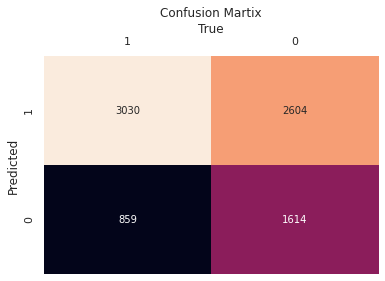

In [20]:
quality(X_train, y_train, NB_model, 'Naive-Bayes', 'training')

Quality of predictions on validation set.

The validation accuracy of Naive-Bayes is 0.58.
The validation precision of Naive-Bayes is 0.54.
The validation recall of Naive-Bayes is 0.79.
The validation F1 of Naive-Bayes is 0.64.



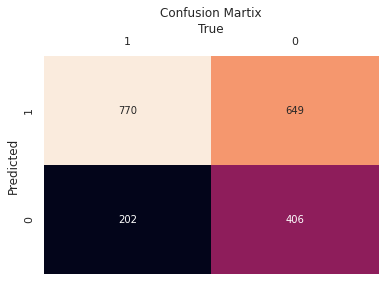

In [23]:
quality(X_valid, y_valid, NB_model, 'Naive-Bayes', 'validation')

Roc curve comparision of training and validation set.

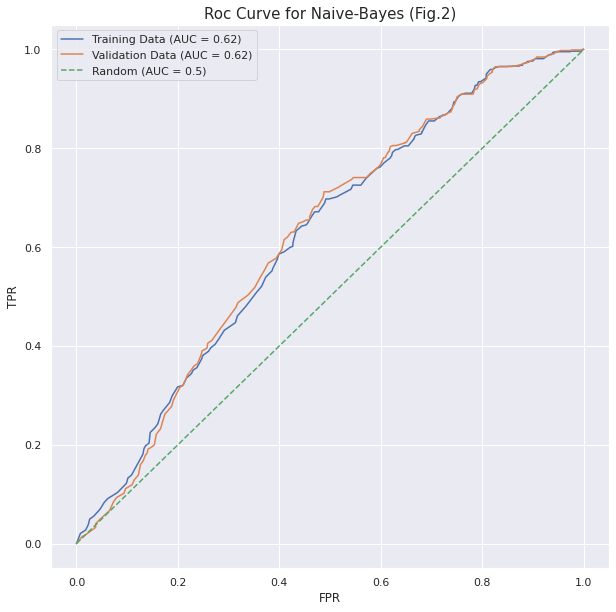

In [22]:
# obtain prediction probablilities
probs_train = NB_model.predict_proba(X_train)[:, 1]
probs_valid = NB_model.predict_proba(X_valid)[:, 1]

# obtain TPR, FPR an AUC for training and validation data.
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, probs_train)
auc_train = metrics.roc_auc_score(y_train, probs_train)
fpr_valid, tpr_valid, _ = metrics.roc_curve(y_valid, probs_valid)
auc_valid = metrics.roc_auc_score(y_valid, probs_valid)

# plot results
fig = plt.figure(figsize=(10, 10))
plt.title('Roc Curve for Naive-Bayes (Fig.2)', fontsize='15')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr_train, tpr_train, label='Training Data (AUC = %.2f)'%auc_train)
plt.plot(fpr_valid, tpr_valid, label='Validation Data (AUC = %.2f)'%auc_valid)
plt.plot([0, 1], [0, 1], linestyle= '--', label='Random (AUC = 0.5)')
plt.legend()
plt.show()

Once again the performance on both the training and validation set seem to be very similar which inicates the model has been well fitted. Most the scores are of the order of 0.6 which suggests that the model is performing slightly better than random. We have a relatively high recall and low precision which indicates a slight overprediction of success with many FP although we do manage to find a large proportion of TP with this model.

In comparision to Logistic regression, Naive-Bayes performs noticeably worse. This is most likely down to the flawed Naive assumption of independence of descriptors which in this case was shown in the data exploration to be untrue with Temperature, Humidity and Solar Radiation being highly correlated.

All these arguments can be made considerably more robust through the use of cross-validation.